In [38]:
# libraries and dependencies
import numpy as np
import math
import matplotlib.pyplot as plt

import os
import sys
import random

import skimage.io as io
import pylab

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader
import torch.utils.data as data
from torch.nn.utils.rnn import pack_padded_sequence
import torch.utils.data as data

import nltk
import time

import git
from git import Repo

from collections import Counter
import requests

%matplotlib inline
sys.path.insert(0,'/home/dnn/Storage8TB/pythonCodeArea/Alfahad/PythonAPI3/home')
# sys.path.append('./coco_ann')
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [39]:
from data_loader import get_loader
from coco import COCO
# from model import EncoderCNN, DecoderRNN

In [40]:
# encoder decoder model

class EncoderCNN(nn.Module):
    def __init__(self, embed_size):
        super(EncoderCNN, self).__init__()
        
        # pretrained model resnet50
        resnet = models.resnet101(pretrained=True)
        
        # we don't want to train the resnet itself
        for param in resnet.parameters():
            param.requires_grad_(False)
            
        ''' removing the final fully connected layers to extract features from the images,
        final fc layer being the output classification layer '''
        modules = list(resnet.children())[:-1]

        '''he forward() method of Sequential accepts any input and forwards it to the first module it contains. 
        It then “chains” outputs to inputs sequentially for each subsequent module, 
        finally returning the output of the last module.'''
        self.resnet = nn.Sequential(*modules)
        # replace the classifier with a fully connected embedding layer

        # linear transformation from features to embed size
        self.embed = nn.Linear(resnet.fc.in_features, embed_size)

    def forward(self, images):
        features = self.resnet(images)
        features = features.view(features.size(0), -1)
        features = self.embed(features)
        return features
    

class DecoderRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers=1):
        
        super(DecoderRNN, self).__init__()
        
        self.embed_size = embed_size
        self.hidden_size = hidden_size
        self.vocab_size = vocab_size
        self.num_layers = num_layers

        '''word embedding is used to represent words in lower dimension numeric vectors, than the one hot encoding.
         so that similar words have similar representations. Embedding will be learned through training process'''
        self.word_embedding = nn.Embedding(self.vocab_size, self.embed_size)

        # Applying LSTM
        self.lstm = nn.LSTM(self.embed_size, 
                            self.hidden_size, 
                            self.num_layers, 
                            batch_first=True)
        
        self.fc = nn.Linear(self.hidden_size, self.vocab_size)
        # self.hidden = (torch.zeros(1, 1, self.hidden_size), torch.zeros(1, 1, self.hidden_size))
        
    
    def forward(self, features, captions):
        
        caption_embed = self.word_embedding(captions[:, :-1])

        '''unsqueeze is used to change the dimension of tensor.
        cat is used to concatenate the given sequence of seq tensors in the given dimension'''
        
        caption_embed = torch.cat((features.unsqueeze(dim=1), caption_embed),1)
        output, self.hidden = self.lstm(caption_embed)
        # print(output.shape)
        output = self.fc(output)
        # print(self.embed_size, self.vocab_size)
        return output

    def sample(self, inputs, states=None, max_len=20):
        " accepts pre-processed image tensor (inputs) and returns predicted sentence (list of tensor ids of length max_len)"
        """Samples captions for given image features."""
        output = []
        (h, c) = (torch.randn(self.num_layers, 1, self.hidden_size).to(inputs.device), 
                  torch.randn(self.num_layers, 1, self.hidden_size).to(inputs.device))
        
        for i in range(max_len):
            x, (h, c) = self.lstm(inputs, (h, c)) # X is lstm output
            x = self.fc(x)
            x = x.squeeze(1)
            predict = x.argmax(dim=1)
            if predict.item() == 1: # 1 is stop index
                break
            output.append(predict.item())
            inputs = self.word_embedding(predict.unsqueeze(0))
        return output

In [41]:
# composing transformations to the testing image set
transforms_test=transforms.Compose([transforms.Resize(256),transforms.RandomCrop(224),
                                                    transforms.RandomHorizontalFlip(),transforms.ToTensor(),
                                                    transforms.Normalize((0.485,0.456,0.406),(0.229,0.224,0.235))])
# create the data_loader
data_loader=get_loader(transform=transforms_test,mode='test')

Vocabulary successfully loaded from vocab.pkl file!


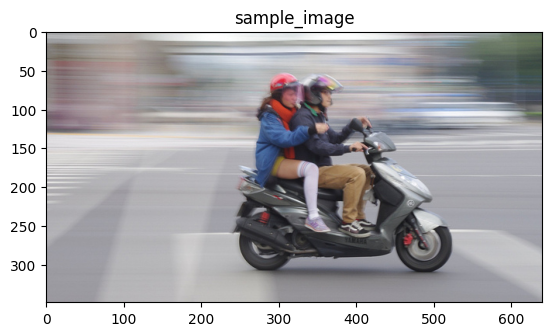

In [42]:
# obtaining the sample image before preprocessing
orig_image,image,path=next(iter(data_loader))

# displaying the sample image taken
plt.imshow(np.squeeze(orig_image))
plt.title('sample_image')
plt.show()

In [43]:
# load the saved encoder decoder weights
encoder_file='encoder-3.pkl'
decoder_file='decoder-3.pkl'

#select suitable values for the variables of the encoder decoder
embed_size=256
hidden_size=512
# size of vocabulary
vocab_size=len(data_loader.dataset.vocab)

#initializing encoder decoder and setting to inference mode
encoder=EncoderCNN(embed_size)
encoder.eval()
decoder=DecoderRNN(embed_size,hidden_size,vocab_size)
decoder.eval()

#loading the trained weigts
encoder.load_state_dict(torch.load(os.path.join('./PythonAPI3/home/models_2',encoder_file)))
decoder.load_state_dict(torch.load(os.path.join('./PythonAPI3/home/models_2',decoder_file)))

#move the models to GPU
encoder.to(device)
decoder.to(device)

DecoderRNN(
  (word_embedding): Embedding(9947, 256)
  (lstm): LSTM(256, 512, batch_first=True)
  (fc): Linear(in_features=512, out_features=9947, bias=True)
)

In [44]:
image = image.to(device)

# Obtain the embedded image features.
features = encoder(image).unsqueeze(1)

# Pass the embedded image features through the model to get a predicted caption.
output = decoder.sample(features)
print('example output:', output)

assert (type(output)==list), "Output needs to be a Python list" 
assert all([type(x)==int for x in output]), "Output should be a list of integers." 
assert all([x in data_loader.dataset.vocab.idx2word for x in output]), "Each entry in the output needs to correspond to an integer that indicates a token in the vocabulary."

example output: [0, 3, 169, 139, 3, 755, 54, 3, 33, 18]


In [45]:
def clean_sentence(output):
    cleaned_list = []
    for index in output:
        if  (index == 1) :
            continue
        cleaned_list.append(data_loader.dataset.vocab.idx2word[index])
    cleaned_list = cleaned_list[1:-1] # Discard <start> and <end> 

    sentence = ' '.join(cleaned_list) # Convert list of string to                                                    
    sentence = sentence.capitalize()    
    return sentence

In [46]:
def get_prediction():
    orig_image, image,path = next(iter(data_loader))
    plt.imshow(np.squeeze(orig_image))
    plt.title('Sample Image')
    plt.show()
    image = image.to(device)
    features = encoder(image).unsqueeze(1)
    output = decoder.sample(features)    
    sentence = clean_sentence(output)
    print(sentence)

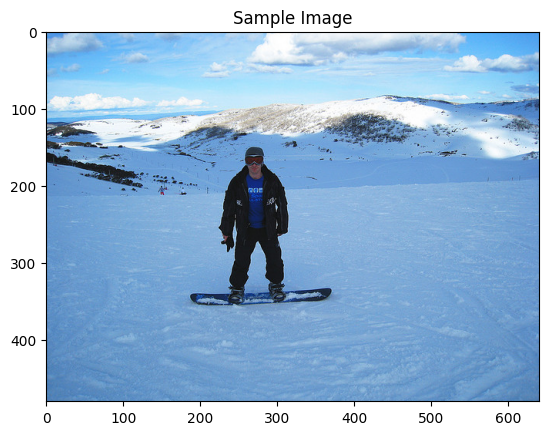

A man riding a skateboard up the side of a ramp


In [60]:
get_prediction()

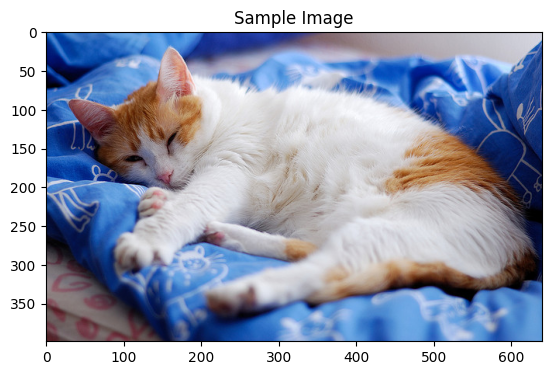

A dog is laying on a bed with a stuffed animal


In [25]:
get_prediction()

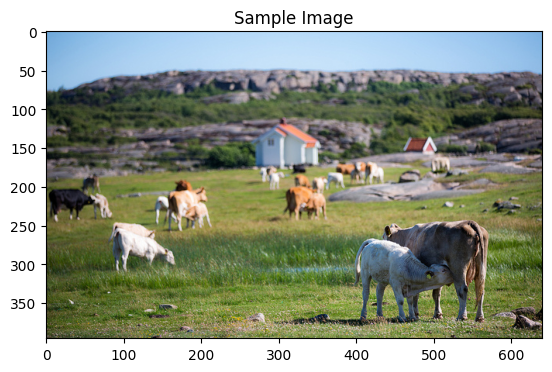

A group of zebras standing in a grassy field


In [63]:
get_prediction()

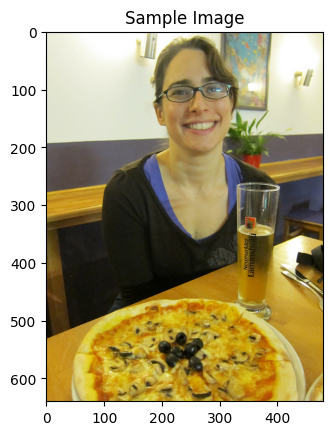

A pizza with cheese and sauce on a plate


In [76]:
get_prediction()

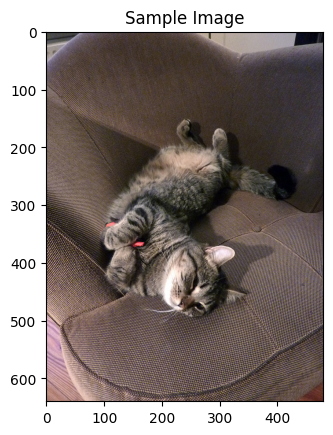

A cat is laying on a bed with a stuffed animal


In [48]:
get_prediction()

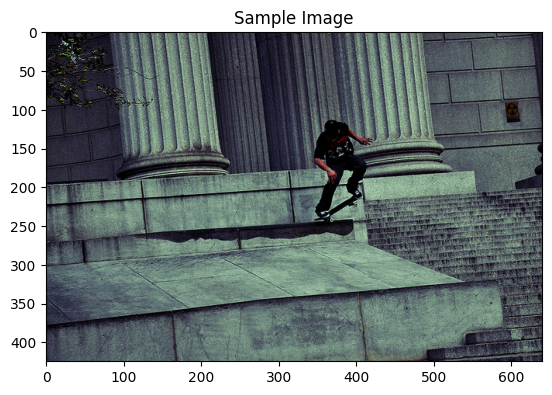

A man riding a skateboard up the side of a ramp


In [50]:
get_prediction()

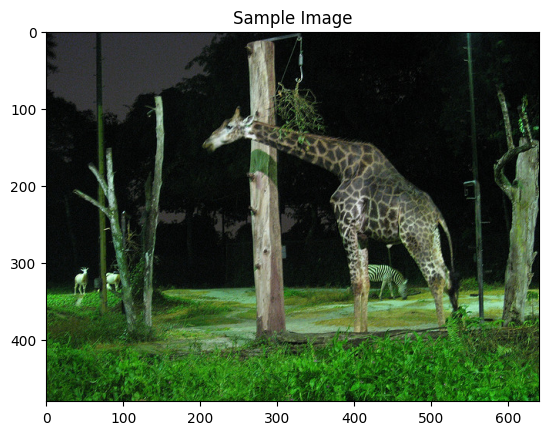

A giraffe standing in a fenced in area


In [59]:
get_prediction()

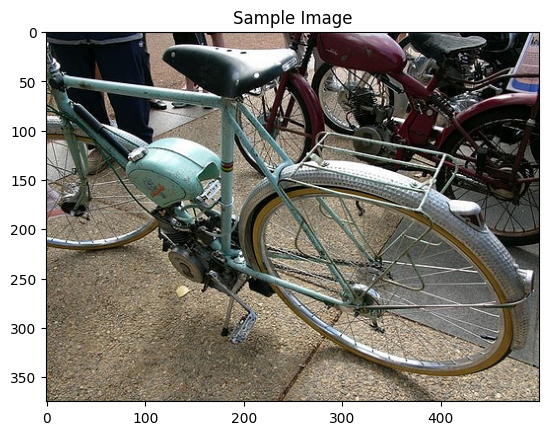

A motorcycle parked on the side of a road


In [83]:
get_prediction()